# Aprendizaje de Máquinas (Machine Learning)
## Clase 4: Clasificación (primera parte)

### 1. Configuración del ambiente

Antes que empezar a trabajar, vamos a preparar el ambiente.
Para ello:
* Montamos Google Drive para guardar allí los archivos que descarguemos. En la consola nos va a aparecer una solicitud para hacer clic en una URL, loggearnos con nuestra cuenta de Google y colocar un código de autorización en una casilla.

In [ ]:
# montar la unidad de google drive
from google.colab import drive
drive.mount('/content/gdrive/')

# crear las carpetas necesarias
from os import makedirs, path
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/'
makedirs(datasets_folder, exist_ok=True)

# importo numpy
import numpy as np
np.set_printoptions(precision=3, suppress=True) # y hago un truco para imprimir solamente 3 decimales

# importo una librería para utilizar valores aleatorios
import random

# importamos pickle para poder ir guardando los distintos modelos
import pickle

# importo matplotlib
import matplotlib.pyplot as plt

Mounted at /content/gdrive/


### 2. Acceso a datos

Vamos a trabajar con uno de los conjuntos de datos que vienen ya pre-cargados en Sklearn, ```breast_cancer```. Es un dataset muy utilizado para enseñar algoritmos de clasificación de machine learning, con un total de 569 muestras.
Ya viene precargado en Sklearn, con lo cual no tendremos necesidad de curarlo. Recuerden que en la práctica uds. tendrán que utilizar otro conjunto distinto y, obviamente, curarlo usando las estrategias que vimos en las clases 1 y 2.

Los datos vienen en un diccionario que tiene un formato distinto al que hemos venido usando. Además, no están particionados en training/val/test, con lo cual nos corresponde a nosotros hacerlo. Vamos primero a darle una ojeada a lo que tenemos.

In [ ]:
from sklearn.datasets import load_breast_cancer

# cargamos el conjunto de datos
data = load_breast_cancer()

# imprimimos el tamaño del data set para chequear que hayamos cargado todo bien
X = data['data']
y = data['target']
print('======================')
print('ORIGINAL BREAST_CANCER DATASET')
print('Num samples: {}'.format(X.shape[0]))
print('Num features: {}'.format(X.shape[1]))
print('Feature names: {}'.format(data.feature_names))
print('Classes: {}'.format(np.unique(y)))
print('Target names: {}'.format(data.target_names))
print('% samples per class: 0 : {:2.2f}%    1 : {:2.2f}%'.format(np.sum(y==0)/y.size*100, np.sum(y==1)/y.size*100))
print('======================')

ORIGINAL BREAST_CANCER DATASET
Num samples: 569
Num features: 30
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Classes: [0 1]
Target names: ['malignant' 'benign']
% samples per class: 0 : 37.26%    1 : 62.74%


Vemos que cada tumor está caracterizado por una serie de valores numéricos que describen sus diferentes propiedades, y que para cada uno tenemos una etiqueta que indica si es maligno o benigno. Además, vemos que una mayoría de los datos corresponde a la clase benigna.

Particionemos los datos, entonces. Es importante que cuando trabajamos con datos para clasificación, intentemos preservar aproximadamente la misma proporción de datos pertenecientes a cada clase. Así, en lugar de dividir los datos aleatoriamente y sin ningún tipo de criterio, deberíamos usar otro tipo de muestreo, conocido como **muestreo estratificado** (stratified). Sklearn nos permite hacer esto relativamente fácil, simplemente usando el parámetro ```stratify``` y pasando la lista de etiquetas.

In [ ]:
from sklearn.model_selection import train_test_split

# inicializamos la estructura donde vamos a guardar nuestro dataset reformateado
dataset = dict()

# asignamos los campos que ya podemos asignar
dataset['feature_labels'] = data.feature_names
dataset['target_names'] = list(data.target_names)

# usamos la rutina train_test_split de Sklearn para dividir los datos en
# training y test (la variable random_state se usa para que siempre obtengamos la
# misma particion aleatoria)
X_train_val, dataset['X_test'], y_train_val, dataset['y_test'] = train_test_split(X, y, test_size=0.30, random_state=10, stratify=y)

# ahora necesitamos partir X_train_val y y_train_val para sacarle el 10% que
# usaremos como validation
dataset['X_train'], dataset['X_val'], dataset['y_train'], dataset['y_val'] = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=11, stratify=y_train_val)

# imprimimos por pantalla los tamaños finales
print('PARTITIONED BREAST_CANCER DATASET')
print('X_train: {}'.format(dataset['X_train'].shape))
print('y_train: {}'.format(dataset['y_train'].shape))
print('% samples per class: 0 : {:2.2f}%    1 : {:2.2f}%'.format(np.sum(dataset['y_train']==0)/dataset['y_train'].size*100, np.sum(dataset['y_train']==1)/dataset['y_train'].size*100))
print('----------------------')
print('X_val: {}'.format(dataset['X_val'].shape))
print('y_val: {}'.format(dataset['y_val'].shape))
print('% samples per class: 0 : {:2.2f}%    1 : {:2.2f}%'.format(np.sum(dataset['y_val']==0)/dataset['y_val'].size*100, np.sum(dataset['y_val']==1)/dataset['y_val'].size*100))
print('----------------------')
print('X_test: {}'.format(dataset['X_test'].shape))
print('y_test: {}'.format(dataset['y_test'].shape))
print('% samples per class: 0 : {:2.2f}%    1 : {:2.2f}%'.format(np.sum(dataset['y_test']==0)/dataset['y_test'].size*100, np.sum(dataset['y_test']==1)/dataset['y_test'].size*100))
print('----------------------')
print('Total: {} samples'.format(dataset['X_train'].shape[0] + dataset['X_val'].shape[0] + dataset['X_test'].shape[0]))
print('======================')

# calculamos la media y el desvio de los datos de entrenamiento
dataset['mu'] = np.mean(dataset['X_train'], axis=0)
dataset['sigma'] = np.std(dataset['X_train'], axis=0)

# normalizamos los datos de entrenamiento, validacion y test usando media y desvio estimado
dataset['X_train'] = (dataset['X_train'] - dataset['mu']) / dataset['sigma']
dataset['X_val'] = (dataset['X_val'] - dataset['mu']) / dataset['sigma']
dataset['X_test'] = (dataset['X_test'] - dataset['mu']) / dataset['sigma']

# salvamos los datos para usarlos más adelante
import pickle
dataset_filename = path.join(datasets_folder, 'breast_cancer_partitioned.pkl')
print('\nSaving {}'.format(dataset_filename))
with open(dataset_filename, 'wb') as f:
    pickle.dump(dataset, f)

PARTITIONED BREAST_CANCER DATASET
X_train: (358, 30)
y_train: (358,)
% samples per class: 0 : 37.15%    1 : 62.85%
----------------------
X_val: (40, 30)
y_val: (40,)
% samples per class: 0 : 37.50%    1 : 62.50%
----------------------
X_test: (171, 30)
y_test: (171,)
% samples per class: 0 : 37.43%    1 : 62.57%
----------------------
Total: 569 samples

Saving /content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/breast_cancer_partitioned.pkl


Como se ve, el muestreo estratificado nos permitió conservar una proporción más o menos equivalente de clases entre los datos de entrenamiento, validación y test. Esto es MUY importante, sobre todo cuando trabajamos con problemas en los que una clase domina significativamente la(s) otra(s). Si no hiciéramos esto, podría ocurrir que observemos diferencias importantes en la performance sobre los datos de validación y test, por ejemplo, debidas solamente a que la distribución de los datos sea muy distinta.

### 3. Regresión logística

El modelo de [regresión logística (logistic regression)](https://en.wikipedia.org/wiki/Logistic_regression) es quizá el modelo de aprendizaje estadístico más simple. Es una reformulación del modelo de regresión lineal aplicado a problemas de clasificación (es decir, a la estimación de una variable discreta acotada en lugar de una variable contínua).

El modelo aprende parámetros $\theta_i$ que se combinan linealmente con cada feature $x_i$.

$\hat{y} = g\left( \sum_{i=1}^d \theta_i · x_i \right)$

La expresión es muy parecida a la del modelo de regresión lineal, pero fíjense que aplica una función $g(z)$ a la salida del modelo de regresión tradicional. Esa función se conoce como función logística, sigmoide(a) o logit, y es la que le da nombre al algoritmo. Su rol es convertir los valores contínuos del modelo de regresión lineal en probabilidades de pertenecer a la clase positiva.

Vamos a entrenar un modelo de regresión logística para predecir si un tumor es maligno (0) o benigno (1), a partir de sus características. 

La forma de inicializar la clase es un poco diferente a la que usamos antes con LinearRegression. El parámetro ```normalize```, que nos servía para normalizar los datos automáticamente, ya no está más, con lo cual debemos asegurarnos que hayamos estandarizado los datos antes. El parámetro ```fit_intercept```, que se usa para predecir la ordenada al origen, se mantiene, y debemos iniciarlo en ```True``` porque no agregamos la columna de 1s en la matriz. Y se agrega un parámetro nuevo, ```penalty```, que ya veremos para qué sirve.

Entrenamos, entonces, el modelo, y lo evaluamos sobre los datos de validación utilizando la métrica de Accuracy que vieron en el curso 1.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# inicializamos un modelo de regresión logística estándar
logistic_regression_model = LogisticRegression(penalty='none', fit_intercept=True)

# lo entrenamos sobre los datos de entrenamiento
logistic_regression_model.fit(dataset['X_train'], dataset['y_train'])

# predecimos sobre los datos de validación
y_hat_val = logistic_regression_model.predict(dataset['X_val'])

# imprimimos la predicción para los primeros 5 datos
print('Logistic regression prediction: {}'.format(y_hat_val[0:5]))
print('Ground truth labels: {}'.format(dataset['y_val'][0:5]))
print('-----------------------')
# y evaluamos sobre todos los datos
basic_log_reg_accuracy_val = accuracy_score(dataset['y_val'], y_hat_val)
print('Accuracy: {}'.format(basic_log_reg_accuracy_val))

# guardamos el mejor modelo como un archivo pickle
model_filename = path.join(datasets_folder, 'breast_cancer_basic_log_reg.pkl')
print('\nSaving {}'.format(model_filename))
with open(model_filename, 'wb') as f:
    pickle.dump({'model': logistic_regression_model}, f)

Logistic regression prediction: [1 0 1 1 0]
Ground truth labels: [1 1 1 1 0]
-----------------------
Accuracy: 0.925

Saving /content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/breast_cancer_basic_log_reg.pkl


Vemos que el algoritmo tiene un Accuracy = 0.925 en los datos de validación. Eso es bueno, significa que tiene más de un 90% de coincidencias con los datos de validación (que todavía nunca habíamos visto).

### 4. Regresión logística regularizada

Así como teníamos modelos de regresión lineal regularizada como Ridge (basado en el cuadrado de la norma euclidea del vector de pesos, o norma L2) y LASSO (basada en la suma del valor absoluto de los pesos, o norma L1), acá también tenemos la posibilidad de incorporar un regularizador. Ese es el famoso parámetro ```penalty``` que hace un rato seteamos en ```'none'```.

Sklearn ofrece varias opciones distintas de regularizadores. Nosotros vamos a trabajar con las mismas dos que vimos en regresión: L1 (```penalty='l1'```) y L2 (```penalty='l2'```). Al igual que antes teníamos un hiperparámetro $\lambda$, acá tenemos un hiperparámetro $C = \frac{1}{\lambda}$ (es decir, la inversa de la "fuerza" de la regularización). Cuando $C$ es alto, el peso del regularizador es más pequeño. Cuando $C$ es bajo, el regularizador se hace más fuerte.

Una salvedad que hay que hacer: puede ocurrir que el optimizador, al cabo de un número máximo de iteraciones, no haya podido converger en una solución estable del problema regularizado. En ese caso, tenemos dos parámetros de ```LogisticRegression``` que podemos usar para tratar de converger: ```max_iter``` y ```solver```. 

Con ```max_iter``` podemos decirle al algoritmo de entrenamiento cuántas iteraciones queremos que use como máximo para encontrar la solución. Por defecto, está en 100. Cuantas más iteraciones le demos, más tiempo va a llevar que el entrenamiento termine, pero tenemos más garantías de alcanzar la convergencia.

Con ```solver``` controlamos qué algoritmo de optimización queremos. Dependiendo del tipo de regularizador, conviene usar uno u otro. [En la documentación de Sklearn tienen recomendaciones](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

Hecho todo este análisis, repitamos el entrenamiento del modelo anterior pero con la norma L2 como regularizador, y monitoreando la performance sobre los datos de validación para distintos valores de $C$. Pueden repetir este análisis después cambiando por la norma L1.


Saving /content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/breast_cancer_l2_reg_log_reg.pkl


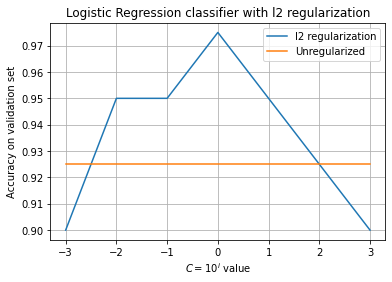

Logistic regression classifier with l2 regularization
-----------------------
Best C: 1
Accuracy on validation set: 0.975
-----------------------


In [ ]:
import matplotlib.pyplot as plt

# valores de C que vamos a probar
C_values = [-3, -2, -1, 0, 1, 2, 3]

# elegimos el regularizador (comentar la linea que no queremos)
regularizer = 'l2'
#regularizer = 'l1'
# automaticamente elegimos el solver más conveniente
if regularizer == 'l2':
  best_solver = 'lbfgs'
elif regularizer == 'l1': 
  best_solver = 'liblinear'
else:
  raise ValueError('Unrecognized {} regularizer. This example only supports {}'.format(regularizer, ['l1', 'l2']))

# inicializamos un vector donde guardaremos los valores de accuracy
reg_log_reg_accuracy_val = np.zeros(len(C_values))
# inicializamos también una lista para guardar cada modelo que entrenemos
reg_log_reg_models = []

# probamos cada valor de C
for i in range(len(C_values)):
  # inicializamos el modelo
  model = LogisticRegression(penalty=regularizer, fit_intercept=True, C=10**(C_values[i]), solver=best_solver, max_iter=1000)
  reg_log_reg_models.append(model)
  # lo entrenamos sobre los datos de entrenamiento
  model.fit(dataset['X_train'], dataset['y_train'])
  # lo corremos sobre los datos de validación
  y_hat_val = model.predict(dataset['X_val'])
  # y evaluamos su accuracy comparando estas etiquetas con el ground truth
  reg_log_reg_accuracy_val[i] = accuracy_score(dataset['y_val'], y_hat_val)

# identificamos el mejor valor de C a partir del accuracy más alto
C_idx = np.argmax(reg_log_reg_accuracy_val)
# lo reservamos
regularized_logistic_regression_model = reg_log_reg_models[C_idx]

# guardamos el mejor modelo como un archivo pickle
model_filename = path.join(datasets_folder, 'breast_cancer_{}_reg_log_reg.pkl'.format(regularizer))
print('\nSaving {}'.format(model_filename))
with open(model_filename, 'wb') as f:
    pickle.dump({'model': regularized_logistic_regression_model}, f)

# mostramos un gráfico ilustrando la evolución del accuracy para cada C
plt.plot(C_values, reg_log_reg_accuracy_val)
plt.plot(C_values, np.ones(len(C_values)) * basic_log_reg_accuracy_val)
plt.xlabel('$C=10^i$ value')
plt.grid()
plt.ylabel('Accuracy on validation set')
plt.title('Logistic Regression classifier with {} regularization'.format(regularizer))
plt.legend(['{} regularization'.format(regularizer), 'Unregularized'])
plt.show(True)

# imprimimos los resultados por pantalla
print('Logistic regression classifier with {} regularization'.format(regularizer))
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('Accuracy on validation set: {}'.format(reg_log_reg_accuracy_val[C_idx]))
print('-----------------------')

Si corremos el código anterior utilizando regularización L2, veremos que la performance en los datos de validación mejora significativamente! Pasamos de un accuracy de 0.925 a uno de 0.975. 

La moraleja es que probemos siempre todo (sobre los datos de validación, por supuesto). Por más que veamos valores de accuracy que nos gusten, siempre podemos mejorarlos un poco más. Para una herramienta que luego pase a producción, es importantísimo asegurarse que exprimimos al máximo los datos, por supuesto, pero también el método!

¿Por qué sobre los datos de validación y no los de test? Porque los de test los reservamos siempre para la prueba final, en donde comparamos la mejor versión de cada algoritmo, uno contra otro.

### 5. Support Vector Machines (SVM)

La [Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) fue durante muchos años el modelo más utilizado para clasificación. Algo así como la red neuronal convolucional de los '90-'10. Hoy por hoy permite resolver muchísimos problemas de clasificación binaria tradicional, sin necesidad de grandes recursos de cómputo y con una performance más que aceptable.

El modelo central de una SVM es lineal, igual que en el caso del de regresión lineal. La notación que usamos es diferente, para estar en línea con lo que escribió la gente que desarrolló el método. Aquí el vector de pesos no es más $\theta$ si no $\mathbf{w}$, con lo cual $f_\theta(\mathbf{x})$ es ahora $f_\mathbf{w}(x)$, y $f_\mathbf{w}(x) = w_d \cdot x_d + ... + w_1 \cdot x_1 + b$. Fíjense que ahora la ordenada al origen tiene su propio símbolo ($b$). Se lo suele llamar "bias" (sesgo), y se separa porque tiene un vínculo matemático con el margen (que no vamos a explorar acá).

Entrenar una SVM equivale a resolver un problema de minimización algo más complejo que el de regresión logística, que involucra per se un regularizador (que puede ser tanto L1 como L2). Por ello es que sí o sí siempre que usemos una SVM vamos a tener que calibrarle su valor de $C$. 

Siguiendo, entonces, la misma lógica que aplicamos antes para regresión logística, entrenemos una SVM con diferentes valores de $C$ y veamos cómo performa sobre los datos de validación. 

En Sklearn, la Support Vector Machine más básica que se usa para clasificación se llama [LinearSVC (Linear Support Vector Classifier)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html), y está dentro del paquete svm. Para crear el objeto necesitamos:
* Indicar el tipo de regularizador que queremos que use (si L1 o L2, como vimos antes). Vamos a usar el mismo regularizador que traemos de la ejecución anterior. Se hace pasándole un string a ```penalty```.
* El valor de $C$ que nos determina el peso de la función de pérdida por sobre el regularizador.
* La orden de que fitteé la ordenada al origen (```fit_intercept```).
* La función de pérdida que queremos que use para medir el error en las predicciones durante el entrenamiento. La definición original de la SVM utiliza la [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss), así que pasémosle ese valor.

Con esto tenemos todo listo para correr el algoritmo.


Saving /content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/breast_cancer_svm.pkl


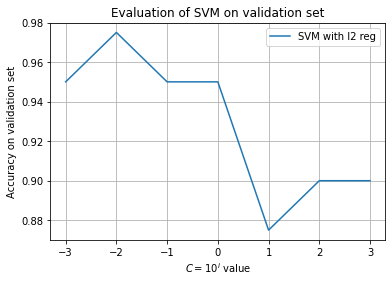

Linear Support Vector Machine classifier with l2 regularization
-----------------------
Best C: 0.01
Accuracy on validation set: 0.975
-----------------------


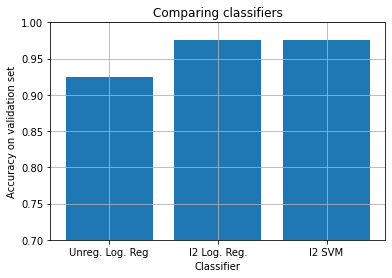

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

# valores de C que vamos a probar
C_values = [-3, -2, -1, 0, 1, 2, 3]

# inicializamos un vector donde guardaremos los valores de accuracy
svm_accuracy_val = np.zeros(len(C_values))
# inicializamos una lista de modelos para ir guardando cada svm
svm_models = []

# probamos cada valor de C
for i in range(len(C_values)):
  # inicializamos el modelo
  model = LinearSVC(C=10**(C_values[i]), penalty=regularizer, fit_intercept=True, max_iter=5000, loss='hinge')
  svm_models.append(model)
  # lo entrenamos sobre los datos de entrenamiento
  model.fit(dataset['X_train'], dataset['y_train'])
  # lo corremos sobre los datos de validación
  y_hat_val = model.predict(dataset['X_val'])
  # y evaluamos su accuracy comparando estas etiquetas con el ground truth
  svm_accuracy_val[i] = accuracy_score(dataset['y_val'], y_hat_val)

# identificamos el mejor valor de C a partir del accuracy más alto
C_idx = np.argmax(svm_accuracy_val)

# guardamos el mejor modelo como un archivo pickle
model_filename = path.join(datasets_folder, 'breast_cancer_svm.pkl')
print('\nSaving {}'.format(model_filename))
with open(model_filename, 'wb') as f:
    pickle.dump({'model': svm_models[C_idx]}, f)

# mostramos un gráfico ilustrando la evolución del accuracy para cada C
plt.plot(C_values, svm_accuracy_val)
plt.xlabel('$C=10^i$ value')
plt.grid()
plt.ylabel('Accuracy on validation set')
plt.title('Evaluation of SVM on validation set')
plt.legend(['SVM with {} reg'.format(regularizer)])
plt.show(True)

# imprimimos los resultados por pantalla
print('Linear Support Vector Machine classifier with {} regularization'.format(regularizer))
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('Accuracy on validation set: {}'.format(svm_accuracy_val[C_idx]))
print('-----------------------')

plt.bar(np.arange(3), np.array([basic_log_reg_accuracy_val, np.max(reg_log_reg_accuracy_val), np.max(svm_accuracy_val)]))
plt.ylim(0.7, 1.0)
plt.ylabel('Accuracy on validation set')
plt.title('Comparing classifiers')
plt.xlabel('Classifier')
plt.grid()
plt.xticks(np.arange(3), ('Unreg. Log. Reg', '{} Log. Reg.'.format(regularizer), '{} SVM'.format(regularizer)))
plt.show()

A partir de estos resultados podemos sacar varias conclusiones.

* Vemos que la SVM performa igual que el regresor logístico (al menos en los datos de validación que estamos usando).
* Vemos también que la SVM supera al regresor logístico no regularizado, para ciertos valores de $C$.
* Vemos que para valores altos de $C$ (que le dan más importancia a la función de costo que al regularizador) la performance decae bastante. Esto puede deberse a cierto overfitting sobre los datos de entrenamiento.
* Vemos que los mejores resultados los obtenemos para valores bajos de $C$ (es decir, dándole cierta relevancia al regularizador). En línea con lo que vimos antes, esto puede vincularse con el hecho de que la SVM puede overfittear bastante fácil, y que requiere que le demos fuerza al regularizador.

### 6. Random Forest

El clasificador por [Random Forest](https://es.wikipedia.org/wiki/Random_forest) funciona de igual forma que el regresor que vimos la clase pasada. El modelo contiene un número $T$ de árboles de decisión que se entrenan a partir de subconjuntos de características y de datos. La respuesta del modelo se determina a partir del majority voting de esos árboles (no el promedio, como sucedía en regresión, ya que queremos obtener un valor de clase y no una variable contínua).

Al igual que el que vimos antes, tiene como hiperparámetro principal $T$ (el número de árboles del bosque). Tenemos el mismo trade-off: valores de $T$ chicos implicarán underfitting, mientras que valores de $T$ grandes implicarán un costo computacional del entrenamiento y el test más elevados.

Dado que ya conocemos cómo funciona el Random Forest para regresión y que en este caso el modelo es muy similar, simplemente lo entrenaremos para diferentes valores de $T$ y lo evaluaremos sobre nuestros datos de validación, para compararlo con los demás métodos.


Saving /content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/breast_cancer_rf.pkl


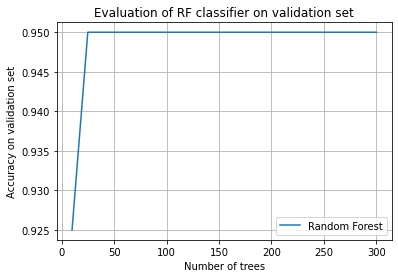

Random Forest Classifier
-----------------------
Best T: 25
Accuracy on validation set: 0.95
-----------------------


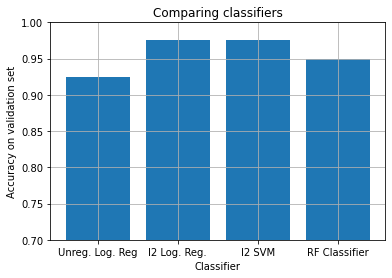

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# numero de arboles
num_trees = [10, 25, 50, 100, 200, 300]
# inicializamos una lista de modelos
rf_models = []

# arreglo para ir guardando los valores de accuracy
rf_accuracy_val = np.zeros(len(num_trees))

# iteramos por cada numero de arboles
i = 0
for N in num_trees:
  # definimos el modelo
  model = RandomForestClassifier(n_estimators=N, random_state=10)
  # lo entrenamos sobre los datos de entrenamiento
  model.fit(dataset['X_train'], dataset['y_train'])
  rf_models.append(model)
  # predecimos sobre los datos de validación
  y_hat_val = model.predict(dataset['X_val'])
  # evaluamos accuracy
  rf_accuracy_val[i] = accuracy_score(dataset['y_val'], y_hat_val)
  i=i+1

# identificamos el mejor valor de T a partir del accuracy más alto
T_idx = np.argmax(rf_accuracy_val)
best_rf_model = rf_models[T_idx]

# guardamos el mejor modelo como un archivo pickle
model_filename = path.join(datasets_folder, 'breast_cancer_rf.pkl')
print('\nSaving {}'.format(model_filename))
with open(model_filename, 'wb') as f:
    pickle.dump({'model': best_rf_model}, f)

# mostramos un gráfico ilustrando la evolución del accuracy para cada T
plt.plot(num_trees, rf_accuracy_val)
plt.xlabel('Number of trees')
plt.grid()
plt.ylabel('Accuracy on validation set')
plt.title('Evaluation of RF classifier on validation set')
plt.legend(['Random Forest'])
plt.show(True)

# imprimimos los resultados por pantalla
print('Random Forest Classifier')
print('-----------------------')
print('Best T: {}'.format(num_trees[T_idx]))
print('Accuracy on validation set: {}'.format(rf_accuracy_val[T_idx]))
print('-----------------------')

plt.bar(np.arange(4), np.array([basic_log_reg_accuracy_val, np.max(reg_log_reg_accuracy_val), np.max(svm_accuracy_val), np.max(rf_accuracy_val)]))
plt.ylim(0.7, 1.0)
plt.ylabel('Accuracy on validation set')
plt.title('Comparing classifiers')
plt.xlabel('Classifier')
plt.grid()
plt.xticks(np.arange(4), ('Unreg. Log. Reg', '{} Log. Reg.'.format(regularizer), '{} SVM'.format(regularizer), 'RF Classifier'))
plt.show()


Podemos observar que hay una cierta diferencia entre la performance de los clasificadores lineales regularizados y el Random Forest. Esto en general puede ocurrir cuando el problema de clasificación que estamos queriendo resolver es linealmente separable. Los algoritmos de Random Forest suelen no funcionar tan bien en estos casos, porque estimar el modelo lineal implica sacrificar muchos árboles de decisión para construir las particiones. En general es recomendable estudiar siempre cómo funciona un clasificador lineal vs. uno no lineal, aunque lo veremos más adelante.

Finalmente, y como ocurría antes en el problema de regresión, acá también podemos estudiar la importancia relativa de las diferentes features con las que trabajamos.

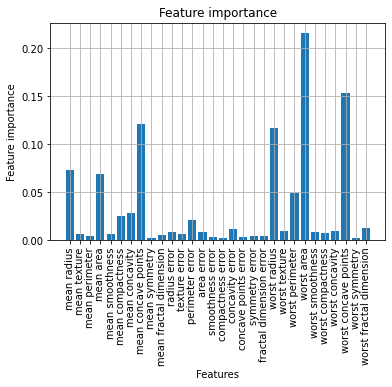

In [ ]:
plt.bar(np.arange(dataset['X_train'].shape[1]), best_rf_model.feature_importances_)
plt.xticks(ticks=np.arange(dataset['X_train'].shape[1]),labels=dataset['feature_labels'],rotation=90)
plt.title('Feature importance')
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.grid(True)
plt.show()

### 7. K-Nearest Neighbors (k-NN)

El clasificador por $k$ vecinos más cercanos (K-Nearest Neighbors, k-NN) tiene quizá la matemática más fácil de seguir. Dada una muestra nueva $\mathbf{x}$, el modelo  estudia su distancia respecto a todas las muestras de entrenamiento a partir de una medida de distancia dada $d$, se queda con las $k$ muestras más cercanas y asigna la etiqueta basándose en la más frecuente entre las $k$.

Para definir [un $k$-NN en Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), necesitamos definir:
* ```n_neighbors```: que es el valor de $k$.
* ```weights```: que es la forma en la que queremos ponderar los vecinos para determinar la clase de cada una.
* ```algorithm```: el método que se use para buscar los vecinos más cercanos. Por fuerza bruta (```brute```) nos asegura comparar todos contra todos.
* ```metric```: la medida de distancia. Por defecto se usa la [distancia de Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance), pero podemos pasarle una función por parámetro que calcule la distancia que nosotros queramos.
* ```p```: es el valor de $p$ de la distancia de Minkowski. Si $p=2$, utilizamos la distancia Euclidea que usamos siempre. En general, con esta suele alcanzar.

Como vimos en la teoría, entrenar un clasificador por $k$-NN consiste simplemente en guardar los datos de entrenamiento. 

La etapa de model selection es crucial acá, porque necesitamos elegir un valor de $k$ adecuado. De igual forma, necesitamos determinar una medida de distancia que nos sirva para estudiar mejor las similitudes entre los datos. 

Alguien podría tentarse y decir: "Y si usamos solamente datos de entrenamiento para elegir $k$? Siendo que no hay nada que entrenar, no partamos el dataset de gusto y listo!". Vamos a ver en el siguiente ejemplo que eso tiene un problema bastante grande:

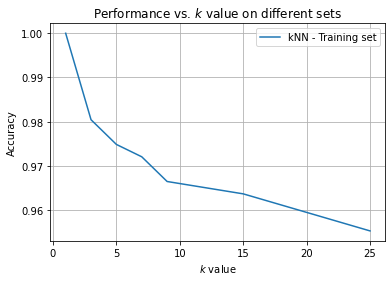

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# definimos un conjunto de valores de K a evaluar
K_values = [1, 3, 5, 7, 9, 15, 25]
# inicializamos un vector donde guardaremos los valores de accuracy sobre los 
# datos de entrenamiento para cada valor de K
knn_accuracy_train = np.zeros(len(K_values))

# probamos cada valor de K
for i in range(len(K_values)):
  # inicializamos el modelo
  model = KNeighborsClassifier(n_neighbors=K_values[i], algorithm='brute')
  # le pasamos los datos de entrenamiento
  model.fit(dataset['X_train'], dataset['y_train'])
  # y lo corremos sobre los mismos
  y_hat_train = model.predict(dataset['X_train'])
  # y evaluamos su accuracy comparando estas etiquetas con el ground truth
  knn_accuracy_train[i] = accuracy_score(dataset['y_train'], y_hat_train)

# identificamos el mejor valor de K a partir del accuracy más alto
K_idx = np.argmax(knn_accuracy_train)

# mostramos un gráfico ilustrando la evolución del accuracy para cada valor de K
plt.plot(K_values, knn_accuracy_train)
plt.xlabel('$k$ value')
plt.grid()
plt.ylabel('Accuracy')
plt.title('Performance vs. $k$ value on different sets')
plt.legend(['kNN - Training set', 'kNN - Validation set'])
plt.show(True)


Eu! 100% de performance sobre los datos de entrenamiento on $k=1$! Con este dato pareciera que $k=1$ nos asegura un clasificador perfecto para este problema. **Bueno, la respuesta es NO.** Por definición, usar un valor de $k=1$ siempre nos va a asegurar un 100% de efectividad sobre los datos de entrenamiento, basicamente porque el decision boundary es un círculo en torno a cada muestra! Con $k=1$ el modelo de $k$-NN tiene un severo overfitting sobre los datos de entrenamiento.

Ignoremos $k=1$, entonces. Podemos seguir tentándonos con probar algún otro valor de $k$ bien bajo, ya que vemos en la curva anterior es que la performance en los datos de entrenamiento cae a medida que uso valores de $k$ más altos. **Bueno, eso también está mal**. Es de esperar que esto ocurra porque para valores de $k$ más grandes empiezo a dibujar decision boundaries que se alejan más de los datos de entrenamiento.

Para elegir el valor de $k$ óptimo (o incluso la medida de distancia) sí o sí necesitamos datos de validación. Los datos de validación son los que modelan el mundo real, y nos van a decir para qué valores de $k$ nuestros datos de entrenamiento empiezan a servir para clasificarlos bien.

Repitamos el análisis anterior pero usando los datos de validación. También aprovechemos y comparemos la performance con la que obtuvimos antes usando los demás modelos (pero en un gráfico aparte):


Saving /content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/breast_cancer_knn.pkl


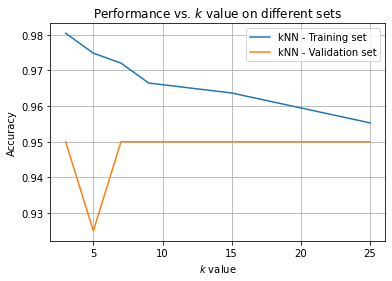

k Nearest Neighbor classifier
-----------------------
Best k on validation set: 3
Accuracy on validation set: 0.95
-----------------------


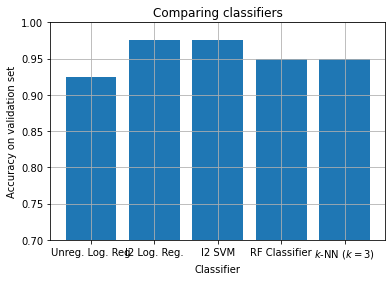

In [ ]:
# redefinamos K_values para evitar buscar valores que no está bueno mirar
K_values = [3, 5, 7, 9, 15, 25]
knn_accuracy_train = knn_accuracy_train[1:]

# inicializamos un vector donde guardaremos los valores de accuracy sobre los 
# datos de validación para cada valor de K
knn_accuracy_val = np.zeros(len(K_values))
knn_models = []

# probamos cada valor de K
for i in range(len(K_values)):
  # inicializamos el modelo
  model = KNeighborsClassifier(n_neighbors=K_values[i], algorithm='brute')
  knn_models.append(model)
  # le pasamos los datos de entrenamiento
  model.fit(dataset['X_train'], dataset['y_train'])
  # lo corremos sobre los datos de validación
  y_hat_val = model.predict(dataset['X_val'])
  # y evaluamos su accuracy comparando estas etiquetas con el ground truth
  knn_accuracy_val[i] = accuracy_score(dataset['y_val'], y_hat_val)

# identificamos el mejor valor de K a partir del accuracy más alto
K_idx = np.argmax(knn_accuracy_val)

# guardamos el mejor modelo como un archivo pickle
model_filename = path.join(datasets_folder, 'breast_cancer_knn.pkl')
print('\nSaving {}'.format(model_filename))
with open(model_filename, 'wb') as f:
    pickle.dump({'model': knn_models[K_idx]}, f)

# mostramos un gráfico ilustrando la evolución del accuracy para cada valor de K
plt.plot(K_values, knn_accuracy_train)
plt.plot(K_values, knn_accuracy_val)
plt.xlabel('$k$ value')
plt.grid()
plt.ylabel('Accuracy')
plt.title('Performance vs. $k$ value on different sets')
plt.legend(['kNN - Training set', 'kNN - Validation set'])
plt.show(True)

# imprimimos los resultados por pantalla
print('k Nearest Neighbor classifier')
print('-----------------------')
print('Best k on validation set: {}'.format(K_values[K_idx]))
print('Accuracy on validation set: {}'.format(knn_accuracy_val[K_idx]))
print('-----------------------')

plt.bar(np.arange(5), np.array([basic_log_reg_accuracy_val, np.max(reg_log_reg_accuracy_val), np.max(svm_accuracy_val), np.max(rf_accuracy_val), knn_accuracy_val[K_idx]]))
plt.ylim(0.7, 1.0)
plt.ylabel('Accuracy on validation set')
plt.title('Comparing classifiers')
plt.xlabel('Classifier')
plt.grid()
plt.xticks(np.arange(5), ('Unreg. Log. Reg', '{} Log. Reg.'.format(regularizer), '{} SVM'.format(regularizer), 'RF Classifier', '$k$-NN ($k=${})'.format(K_values[K_idx])))
plt.show()

Vemos ahora que en los datos de validación la performance se mantiene bastante constante, en torno al 95% de accuracy, excepto para $k=5$, donde hay una caída.
Esto quiere decir que $k$-NN está saturando su performance, y no puede mejorarla en ningún caso. 

Esto puede ocurrir por ejemplo en situaciones en la que los datos sean fáciles de separar utilizando un hiperplano (lo vamos a ver en la próxima clase). Parecería que este es el caso, dado que los modelos lineales andan bastante bien sobre los datos de validación. 

Otro motivo puede ser que la partición que elegimos no sea demasiado representativa. Cuando esto ocurre, lo ideal es dejar de utilizar una partición fija de training/validation/test y estimar el mejor valor de $k$ usando cross-validation sobre un conjunto formado por los datos [training, validation] todos juntos. No tenemos garantías de que esto no ocurra en ese caso, pero al menos probaremos combinaciones aleatorias de datos que pueden llegar a resolver el problema.